<a href="https://colab.research.google.com/github/mrrestre/DriverGame/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title # Select the subject to be used { display-mode: "both" }
variable_name = ""

subject = '027'

# Install python libraries and load packages

In [2]:
# @title Install needed libraries { display-mode: "both" }
!pip install pyedflib
!pip install pandas

In [3]:
# @title Import libraries { display-mode: "both" }
import subprocess
import pyedflib
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import timedelta
from datetime import datetime

# Import data

In [4]:
# @title Define constants
base_url = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject
orig_data = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject
output_directory = "results/subject" + subject + "/"

In [5]:
# @title Import the data from physionet { display-mode: "both" }

base_command = "wget -r -N -c -np "

rec_path = base_url + ".rec"
sleep_annotation_path = base_url + "_stage.txt"
apnea_annotation_path = base_url + "_respevt.txt"

command = base_command + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + sleep_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + apnea_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Prepare the data

In [6]:
# @title Create output directory for subject

# Create results folder if not exists
if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [7]:
# @title Extract signals from .rec file - results/subject[XXX]/orig_signals.csv { display-mode: "both" }

# open the input file
rec_file_path = orig_data + ".rec"
f = pyedflib.EdfReader(rec_file_path)

# Specify the output file name
signals_csv = output_directory + "orig_signals.csv"

# Specify which signals to use
spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    date_str = start_time.strftime('%Y-%m-%d')
    if start_time.microsecond != 0:
       time_str = start_time.strftime('%H:%M:%S.%f')
    else:
       time_str = start_time.strftime('%H:%M:%S')
    data.append([date_str, time_str, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Write the data to a CSV file
with open(signals_csv, 'w', newline='') as file:
    # Create a CSV writer object for the output file
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Date', 'Time', 'SpO2', 'Pulse'])
    writer.writerows(data)
f.close()

In [8]:
# @title Extract data from respevt.txt file - results/subject[XXX]/apnea_annotations.csv { display-mode: "both" }

# Specify the input file name
annotations_path = orig_data + "_respevt.txt"

# Specify the output file name
output_csv_annotations = output_directory + "apnea_annotations.csv"

# Open the input file
with open(annotations_path, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)

    # Open a CSV file for writing with more parameters
    with open(output_csv_annotations, 'w', newline='') as outfile_extra:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_extra)

        # Write the header
        writer.writerow(['Time', 'Apnea'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:

                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2] if columns[2] != "EVENT" else columns[4]


                # Parse duration into seconds
                duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):

                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type])

                    # Add one second to the time
                    time += timedelta(seconds=1)

In [9]:
# @title Extract data from "stage.txt" file to results/subject[XXX]/sleep_stages.csv

# Specify the input file name
input_stage = orig_data + "_stage.txt"

# Specify the output file name
output_csv_stage = output_directory + "sleep_stages.csv"

# Open the input text file in read mode and the output CSV file in write mode
with open(input_stage, 'r') as infile:
  with open(output_csv_stage, 'w', newline='') as outfile_stage:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_stage)

        # Write the header
        writer.writerow(['Sleep Stage'])

        # Process each line in the input file
        for line in infile:
            # Remove leading and trailing whitespace and split the line into columns
            line = line.strip()
            # Write the sleep stage value to the CSV file
            writer.writerow([line])

In [10]:
# @title Sort the data in the orig_signals.csv and merge it with sleep_stages.csv and apnoe_annotations.csv

merged_csg = output_directory + "merged.csv"

# Load data from the _signals.csv file
df_signals = pd.read_csv(signals_csv)

# Sort the data to keep only the rows where the time values have seconds only
df_signals = df_signals[df_signals['Time'].str.contains(r'^\d{2}:\d{2}:\d{2}$')]
df_signals_withoutmiliseconds = df_signals.copy()

# Load data from the apnea_annotations.csv file and merge it with the filtered signal data using the 'Time' column
df_apnea_anno = pd.read_csv(output_csv_annotations)
df_merged_anno = pd.merge(df_signals_withoutmiliseconds, df_apnea_anno, on='Time', how='left')

# =================================================================================================

# Load data from the sleep_stages.csv file
df_apnea_stage = pd.read_csv(output_csv_stage, dtype=int)

# Initialize an empty list to store combined data
combined_data = []

for i in range(len(df_signals_withoutmiliseconds)):
    # Calculate the index for the data from df_apnea_stage based on the 30-second intervals
    apnea_index = i // 30

    # Ensure the index does not exceed the number of rows in df_apnea_stage
    apnea_index = min(apnea_index, len(df_apnea_stage) - 1)

    # Append the corresponding entry from df_apnea_stage to the combined data list
    combined_data.append(df_apnea_stage.iloc[apnea_index].tolist())

# Convert the combined data list into a DataFrame
df_combined_stage = pd.DataFrame(combined_data, columns=df_apnea_stage.columns)

# Merge the combined data with the merged signal and annotation data
df_merged_stage = pd.concat([df_merged_anno, df_combined_stage], axis=1)

# Save the merged data to a new CSV file
df_merged_stage.to_csv(merged_csg, index=False)

# Data Analysis

# Visualizations

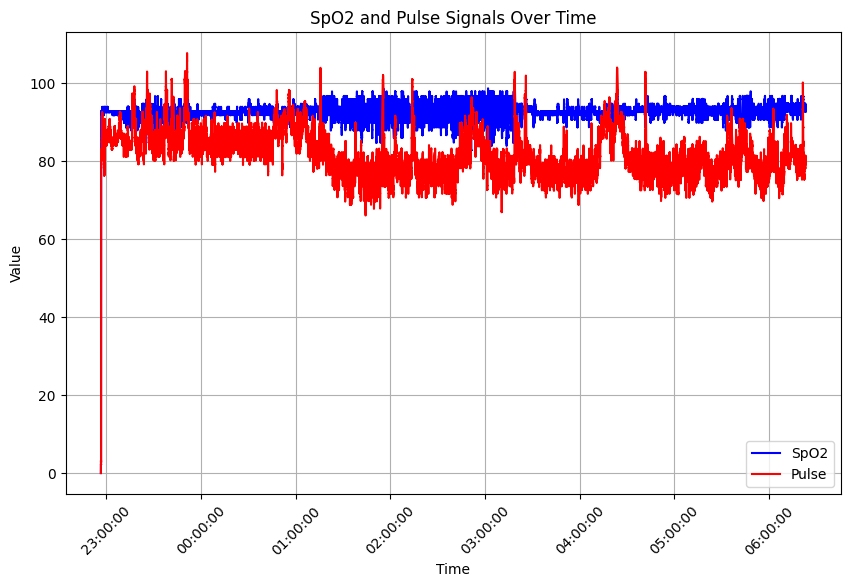

In [11]:
# @title Plot the signals from orig_signals.csv { display-mode: "both" }

plot_png = output_directory + "signals_plot.png"


# Load CSV data into a DataFrame assuming the order of columns is timestamp, spo2, and pulse
df = pd.read_csv(signals_csv)

# Assuming the columns are in order: date, time, spo2, and pulse
date = df['Date']
time = df['Time']
spo2 = df['SpO2']
pulse = df['Pulse']

# Combine date and time into a single string column 'Timestamp'
df['Timestamp'] = df['Date'] + ' ' + df['Time']

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in df['Timestamp']:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, df['SpO2'], label='SpO2', color='blue')
plt.plot(datetime_objects, df['Pulse'], label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
#plt.ylim(60, 110)
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot to a file
plt.savefig(plot_png)

# Show the plot
plt.show()
